# {mod}`torchvision.transforms.v2`



In [ ]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import decode_image

torch.manual_seed(1)

# If you're trying to run that on Colab, you can download the assets and the
# helpers from https://github.com/pytorch/vision/tree/main/gallery/
from helpers import plot
# img = decode_image(str(Path('../assets') / 'astronaut.jpg'))
img = decode_image("../../images/astronaut.jpg")
print(f"{type(img) = }, {img.dtype = }, {img.shape = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.uint8, img.shape = torch.Size([3, 512, 512])


Torchvision 的转换行为类似于常规的 {class}`torch.nn.Module` 类（实际上，它们中的大多数都是）：实例化转换器，传入输入，然后获取转换后的输出：

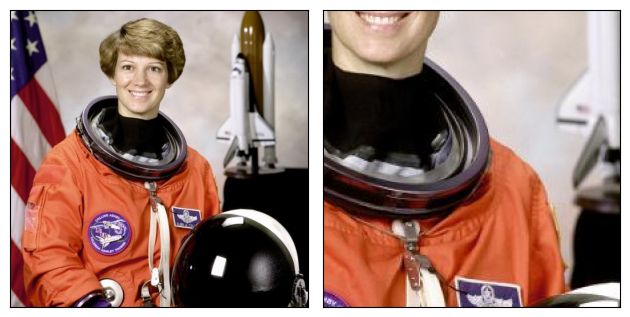

In [2]:
transform = v2.RandomCrop(size=(224, 224))
out = transform(img)

plot([img, out])

基本的分类流水线可能看起来是这样的：

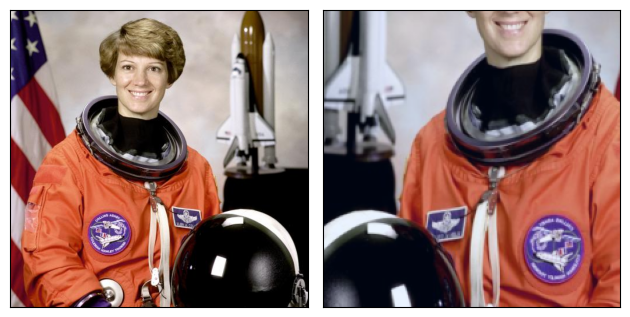

In [3]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
out = transforms(img)

plot([img, out])

这种转换管道通常作为 `transform` 参数传递给 [`Datasets`](https://pytorch.org/vision/master/datasets.html#datasets), 例如 `ImageNet(..., transform=transforms)`。

## 检测、分割、视频

在 {mod}`torchvision.transforms.v2` 命名空间中的新 Torchvision transforms 支持图像分类以外的任务：它们还可以转换边界框、分割/检测掩码或视频。

简要看一下带有边界框的检测示例：

<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>


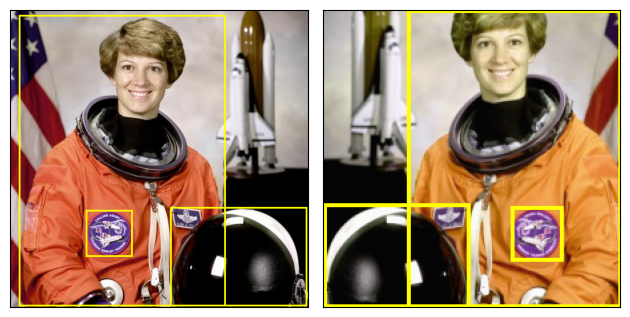

In [4]:
from torchvision import tv_tensors  # we'll describe this a bit later, bare with us

boxes = tv_tensors.BoundingBoxes(
    [
        [15, 10, 370, 510],
        [275, 340, 510, 510],
        [130, 345, 210, 425]
    ],
    format="XYXY", canvas_size=img.shape[-2:])

transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomHorizontalFlip(p=1),
])
out_img, out_boxes = transforms(img, boxes)
print(type(boxes), type(out_boxes))

plot([(img, boxes), (out_img, out_boxes)])

上述例子主要关注于物体检测。但如果有针对物体分割或语义分割的掩模({class}`torchvision.tv_tensors.Mask`)，或者视频({class}`torchvision.tv_tensors.Video`)，完全可以用同样的方式将它们传递给变换器。

到目前为止，你可能有几个问题：这些 TVTensors 是什么？如何使用它们？这些变换器的输入和输出分别是什么？将在接下来的部分回答这些问题。

## 什么是 TVTensors？

TVTensors 是 {class}`torch.Tensor` 的子类。可用的 TVTensors 包括
{class}`~torchvision.tv_tensors.Image`，
{class}`~torchvision.tv_tensors.BoundingBoxes`，
{class}`~torchvision.tv_tensors.Mask` 以及
{class}`~torchvision.tv_tensors.Video`。

TVTensors看起来和感觉就像普通的张量一样——它们**就是**张量。在普通 {class}`torch.Tensor` 上支持的所有功能，比如 `.sum()` 或任何 `torch.*` 算子，也同样适用于TVTensor：

In [5]:
img_dp = tv_tensors.Image(torch.randint(0, 256, (3, 256, 256), dtype=torch.uint8))

print(f"{isinstance(img_dp, torch.Tensor) = }")
print(f"{img_dp.dtype = }, {img_dp.shape = }, {img_dp.sum() = }")

isinstance(img_dp, torch.Tensor) = True
img_dp.dtype = torch.uint8, img_dp.shape = torch.Size([3, 256, 256]), img_dp.sum() = tensor(25087958)


这些TVTensor类是变换的核心：为了转换给定的输入，变换首先查看对象的**类别**，然后根据具体情况分派到适当的实现。

## 需要传递什么作为输入？

在上面，我们看到了两个例子：一个是我们将单个图像作为输入，即``out = transforms(img)``，另一个是将图像和边界框一起传递，即``out_img, out_boxes = transforms(img, boxes)``。

事实上，变换支持**任意输入结构**。输入可以是单张图像、元组、任意嵌套的字典……几乎可以是任何东西。相同的结构将作为输出返回。下面，我们使用相同的检测变换，但传递元组（图像，目标字典）作为输入，并且我们得到了相同的结构作为输出：

('arbitrary', {'structure': '!'})


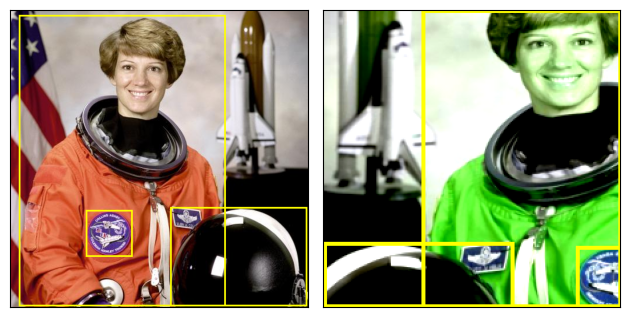

In [6]:
target = {
    "boxes": boxes,
    "labels": torch.arange(boxes.shape[0]),
    "this_is_ignored": ("arbitrary", {"structure": "!"})
}

# Re-using the transforms and definitions from above.
out_img, out_target = transforms(img, target)

plot([(img, target["boxes"]), (out_img, out_target["boxes"])])
print(f"{out_target['this_is_ignored']}")

传递了元组，因此返回的也是元组，第二个元素是转换后的目标字典。变换并不真正关心输入的结构；如前所述，它们只关心对象的**类型**，并根据类型进行相应的转换。

像字符串或整数这样的“外部”对象会被直接传递。例如，在调试时，你可能希望将路径与每个样本关联起来！

```{note}

纯 `torch.Tensor` 对象通常被视为图像（或对于特定于视频的变换，则被视为视频）。确实，您可能已经注意到，在上面的代码中，我们根本没有使用 {class}`torchvision.tv_tensors.Image` 类，但我们的图像仍然得到了正确的转换。变换遵循以下逻辑来确定一个纯张量是否应该被视为图像（或视频），还是仅仅被忽略：

* 如果输入中有 {class}`torchvision.tv_tensors.Image`、{class}`torchvision.tv_tensors.Video` 或 {class}`PIL.Image.Image` 实例，所有其他纯张量都会被直接传递。
* 如果没有 {class}`torchvision.tv_tensors.Image` 或 {class}`torchvision.tv_tensors.Video` 实例，只有第一个纯 {class}`torch.Tensor` 会被视为图像或视频进行转换，而所有其他张量将被直接传递。这里的“第一个”指的是“深度优先遍历”中的第一个。

这正是在上述检测示例中发生的事情：第一个纯张量是图像，因此它得到了正确的转换，而所有其他纯张量实例（如 `labels`）被直接传递了（尽管标签仍然可以通过某些变换，如 {class}`torchvision.transforms.v2.SanitizeBoundingBoxes` 进行转换！）。
```

## 变换和数据集的兼容性

大致来说，数据集的输出必须对应于变换的输入。这取决于您使用的内置数据集 {mod}`~torchvision.datasets`，还是您自己的自定义数据集。



### 使用内置数据集

如果您只是进行图像分类，那么您不需要做任何事情。只需使用数据集的 `transform` 参数，例如 `ImageNet(..., transform=transforms)`，然后就可以开始了。

Torchvision 还支持用于目标检测或分割的数据集，如 {class}`torchvision.datasets.CocoDetection`。这些数据集早于 {mod}`torchvision.transforms.v2` 模块和 TVTensors 的存在，因此它们不会默认返回 TVTensors。

一种简单的方法是强制这些数据集返回 TVTensors，并与 v2 变换兼容，可以使用 {func}`torchvision.datasets.wrap_dataset_for_transforms_v2` 函数：

```python
from torchvision.datasets import CocoDetection, wrap_dataset_for_transforms_v2

dataset = CocoDetection(..., transforms=my_transforms)
dataset = wrap_dataset_for_transforms_v2(dataset)
# 现在数据集返回 TVTensors!
```

### 使用您的自定义数据集

如果您需要自定义数据集，那么您需要将对象转换为适当的 TVTensor 类。创建 TVTensor 实例非常简单，有关更多详细信息，请参阅 [`tv_tensor_creation`](https://pytorch.org/vision/master/auto_examples/transforms/plot_tv_tensors.html#tv-tensor-creation)。

您可以在两个主要位置实现这种转换逻辑：

- 在数据集的 `__getitem__` 方法的末尾返回样本之前（或通过子类化数据集）。
- 作为变换流水线的第一步

无论哪种方式，逻辑都取决于您的具体数据集。